In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [12]:
# Read in the csv containing the contest data and modelled player 3 point make data from the previous stage
df_all = pd.read_csv('CleanedData.csv', index_col=0)
df_all.head()

,Season,ThreePointers,ThreePointersAttempted,ThreePointersMissed,ThreePointersMadePct
Name,,,,,
A.J. Hammons,2017.0,5,10,5,0.500000
A.J. Lawson,2023.0,10,25,15,0.400000
A.J. Lawson,2024.0,12,36,24,0.333333
A.J. Price,2010.0,60,174,114,0.344828
A.J. Price,2011.0,48,165,117,0.290909


In [4]:
#TODO update HistoricalResults csv with 2023-24 information

# historical 3 point contest results
df_historical = pd.read_csv('3PtHistoricalResults.csv')

# fill NA with 0s
df_historical = df_historical.fillna(0)
df_historical.head()

,name,made,att,dewmade,dewatt
0,Seth Curry,13,25,0.0,0.0
1,Stephen Curry,173,225,3.0,4.0
2,Buddy Hield,56,75,0.0,4.0
3,Damian Lillard,13,25,0.0,0.0
4,Kyle Korver,14,25,0.0,0.0


In [13]:
# Generate a player's 'ability' to make a 3 pointer

df = df_all.copy()
players = df.index.unique()

player_ability_dict = {
    "Player": [],
    "Avg_W": [],
    "Avg_NW": []
}

for player in players:
    df_player = df.loc[df.index == player]
    player_ability_dict['Player'].append(player)
    
    num_seasons = len(df_player['Season'].unique())

    # weight of 1, 2, 3 and so on
    weights = np.arange(1, num_seasons + 1)
    weighted_avg = np.average(np.array(df_player['ThreePointersMadePct']), weights=weights)
    player_ability_dict['Avg_W'].append(weighted_avg)

    # no weight, everything equal
    no_weight_avg = np.average(np.array(df_player['ThreePointersMadePct']))
    player_ability_dict['Avg_NW'].append(no_weight_avg)
    
pd.DataFrame.from_dict(player_ability_dict)

,Player,Avg_W,Avg_NW
0,A.J. Hammons,0.500000,0.500000
1,A.J. Lawson,0.355556,0.366667
2,A.J. Price,0.293123,0.302846
3,AJ Green,0.401978,0.406245
4,AJ Griffin,0.311805,0.331344
...,...,...,...
1956,Zion Williamson,0.372207,0.372778
1957,Zoran Dragic,0.214286,0.214286
1958,Zoran Planinic,0.286526,0.293290
1959,Zydrunas Ilgauskas,0.171292,0.172077


In [14]:
df_reset = df_all.reset_index()

# Getting just their 2024 make percentage
df_2024 = df_reset.loc[df_reset['Season'] == 2024][['Name', 'ThreePointersMadePct']]
df_2024 = df_2024.rename(columns={'Name': 'Player', 'ThreePointersMadePct': '2024_Avg_Pct'})

df_ability = pd.DataFrame.from_dict(player_ability_dict)
df_ability = pd.merge(df_ability, df_2024)

# this is each player's global ability, so their 3 point make % in the NBA generally using 3 different metrics
df_ability

,Player,Avg_W,Avg_NW,2024_Avg_Pct
0,A.J. Lawson,0.355556,0.366667,0.333333
1,AJ Green,0.401978,0.406245,0.393443
2,AJ Griffin,0.311805,0.331344,0.272727
3,Aaron Gordon,0.324189,0.317033,0.293333
4,Aaron Holiday,0.395536,0.385910,0.406504
...,...,...,...,...
498,Zach Collins,0.335717,0.334826,0.290323
499,Zach LaVine,0.376586,0.374655,0.349112
500,Zeke Nnaji,0.339148,0.363858,0.312500
501,Ziaire Williams,0.295876,0.295684,0.314103


In [15]:
# Each player's actual 3 point make % from historical 3 point contest data
df_historical['Actual'] = df_historical['made'] / df_historical['att']
df_historical['dewActual'] = df_historical['dewmade'] / df_historical['dewatt']
df_historical = df_historical.fillna(0)
df_historical.head()

,name,made,att,dewmade,dewatt,Actual,dewActual
0,Seth Curry,13,25,0.0,0.0,0.520000,0.00
1,Stephen Curry,173,225,3.0,4.0,0.768889,0.75
2,Buddy Hield,56,75,0.0,4.0,0.746667,0.00
3,Damian Lillard,13,25,0.0,0.0,0.520000,0.00
4,Kyle Korver,14,25,0.0,0.0,0.560000,0.00


In [16]:
# Model each player's 3 point make ability specifically in the 3 point contest

# let's use the weighted average
df_global_ability = df_ability[['Player', 'Avg_W']]
df_global_ability = df_global_ability.rename(columns={'Avg_W': 'Make3Perc'})

# only take the global abilities from players who have played in the 3 point contest previously
df_global_players = df_global_ability[df_global_ability['Player'].isin(df_historical['name'].tolist())]
df_global_players = df_global_players.fillna(0)

print(df_global_players.shape)
print(df_historical.shape)

# there are 5 players who have played in the 3 point contest who we don't seem to have any data for 
no_data_players = [p for p in df_historical['name'].tolist() if p not in df_global_players['Player'].tolist()]
print(no_data_players)

# none of these players are ones who are competing in the upcoming 3 point contest so we can ignore
df_historical = df_historical[~df_historical['name'].isin(no_data_players)]
df_global_players = df_global_players[~df_global_players['Player'].isin(no_data_players)]

print(df_global_players.shape)
print(df_historical.shape)

(35, 2)
(40, 7)
['Kyle Korver', 'J.J. Redick', 'Dirk Nowitzki', 'Kemba Walker', 'Marco Belinelli']
(35, 2)
(35, 7)


In [17]:
# order the two tables so that the names are in the same order
df_global_players = df_global_players.reset_index()
df_historical = df_historical.sort_values('name').reset_index()

print(df_global_players.head())
print(df_historical.head())

   index          Player  Make3Perc
0     43    Bradley Beal   0.356924
1     55     Buddy Hield   0.397410
2     56   C.J. McCollum   0.399027
3     98  Damian Lillard   0.364806
4    101     Danny Green   0.342776
   index            name  made  att  dewmade  dewatt    Actual  dewActual
0     39    Bradley Beal    15   25      0.0     0.0  0.600000        0.0
1      2     Buddy Hield    56   75      0.0     4.0  0.746667        0.0
2     17   C.J. McCollum    24   50      0.0     0.0  0.480000        0.0
3      3  Damian Lillard    13   25      0.0     0.0  0.520000        0.0
4     22     Danny Green    16   25      0.0     0.0  0.640000        0.0


In [18]:
# Merge the two dataframes into one and rename the columns for better readability
df_contest_merged = pd.merge(df_global_players, df_historical, left_on='Player', right_on='name')[['Player', 'Make3Perc', 'made', 'att', 'dewmade', 'dewatt', 'Actual', 'dewActual']]
df_contest_merged = df_contest_merged.rename(columns={'Make3Perc': 'GlobalMake', 'Actual': 'ContestMakeActual', 'dewActual': 'dewContestMakeActual'})
df_contest_merged.head()

,Player,GlobalMake,made,att,dewmade,dewatt,ContestMakeActual,dewContestMakeActual
0,Bradley Beal,0.356924,15,25,0.0,0.0,0.600000,0.0
1,Buddy Hield,0.397410,56,75,0.0,4.0,0.746667,0.0
2,C.J. McCollum,0.399027,24,50,0.0,0.0,0.480000,0.0
3,Damian Lillard,0.364806,13,25,0.0,0.0,0.520000,0.0
4,Danny Green,0.342776,16,25,0.0,0.0,0.640000,0.0


In [21]:
# need to just give the glm non zero data otherwise it will error on the fit
df_non_zero = df_contest_merged[df_contest_merged['att'] != 0]

# We're essentially trying to predict the ContestMakeActual given the GlobalMake and giving the previous historical 3 point contest
# attempts as weights. We use a binomial because a shot is either in or not.
glm_3pt_contest = smf.glm('ContestMakeActual ~ GlobalMake', data=df_non_zero, freq_weights=df_non_zero['att'], family=sm.families.Binomial())

res = glm_3pt_contest.fit()
print(res.summary())

print("Coefficeients")
print(res.params)
print("p-Values")
print(res.pvalues)
print("Dependent variables")
print(res.model.endog_names)

predicted = res.predict(df_contest_merged)
df_contest_merged['ProjectedMake'] = predicted
df_contest_merged.head()

                 Generalized Linear Model Regression Results                  
Dep. Variable:      ContestMakeActual   No. Observations:                   30
Model:                            GLM   Df Residuals:                     1648
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -731.27
Date:                Fri, 02 Feb 2024   Deviance:                       64.893
Time:                        18:02:51   Pearson chi2:                     64.9
No. Iterations:                     4   Pseudo R-squ. (CS):             0.3607
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7022      0.874     -3.092      0.0

,Player,GlobalMake,made,att,dewmade,dewatt,ContestMakeActual,dewContestMakeActual,ProjectedMake
0,Bradley Beal,0.356924,15,25,0.0,0.0,0.600000,0.0,0.562628
1,Buddy Hield,0.397410,56,75,0.0,4.0,0.746667,0.0,0.642658
2,C.J. McCollum,0.399027,24,50,0.0,0.0,0.480000,0.0,0.645726
3,Damian Lillard,0.364806,13,25,0.0,0.0,0.520000,0.0,0.578611
4,Danny Green,0.342776,16,25,0.0,0.0,0.640000,0.0,0.533635


In [22]:
# do the same for the dew balls
df_non_zero = df_contest_merged[df_contest_merged['dewatt'] != 0]

glm_dewball = smf.glm('dewContestMakeActual ~ GlobalMake', data=df_non_zero, freq_weights=df_non_zero['dewatt'], family=sm.families.Binomial())

res_dew = glm_dewball.fit()
print(res_dew.summary())

print("Coefficeients")
print(res_dew.params)
print("p-Values")
print(res_dew.pvalues)
print("Dependent variables")
print(res_dew.model.endog_names)

predicted_dew = res_dew.predict(df_contest_merged)

df_contest_merged['DewProjectedMake'] = predicted_dew
df_contest_merged.head()

                  Generalized Linear Model Regression Results                   
Dep. Variable:     dewContestMakeActual   No. Observations:                   18
Model:                              GLM   Df Residuals:                       58
Model Family:                  Binomial   Df Model:                            1
Link Function:                    Logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -30.135
Date:                  Fri, 02 Feb 2024   Deviance:                       23.774
Time:                          18:02:53   Pearson chi2:                     18.7
No. Iterations:                       3   Pseudo R-squ. (CS):          2.758e-05
Covariance Type:              nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6438      4.375

,Player,GlobalMake,made,att,dewmade,dewatt,ContestMakeActual,dewContestMakeActual,ProjectedMake,DewProjectedMake
0,Bradley Beal,0.356924,15,25,0.0,0.0,0.600000,0.0,0.562628,0.365040
1,Buddy Hield,0.397410,56,75,0.0,4.0,0.746667,0.0,0.642658,0.367417
2,C.J. McCollum,0.399027,24,50,0.0,0.0,0.480000,0.0,0.645726,0.367512
3,Damian Lillard,0.364806,13,25,0.0,0.0,0.520000,0.0,0.578611,0.365502
4,Danny Green,0.342776,16,25,0.0,0.0,0.640000,0.0,0.533635,0.364211


In [23]:
# Let's look at the results of the fit.
# Fit for dewContestMakePred does not look good, but most likely this is due to lack of data
df_contest_merged

,Player,GlobalMake,made,att,dewmade,dewatt,ContestMakeActual,dewContestMakeActual,ProjectedMake,DewProjectedMake
0,Bradley Beal,0.356924,15,25,0.0,0.0,0.600000,0.000000,0.562628,0.365040
1,Buddy Hield,0.397410,56,75,0.0,4.0,0.746667,0.000000,0.642658,0.367417
2,C.J. McCollum,0.399027,24,50,0.0,0.0,0.480000,0.000000,0.645726,0.367512
3,Damian Lillard,0.364806,13,25,0.0,0.0,0.520000,0.000000,0.578611,0.365502
4,Danny Green,0.342776,16,25,0.0,0.0,0.640000,0.000000,0.533635,0.364211
5,Davis Bertans,0.392569,29,50,2.0,4.0,0.580000,0.500000,0.633405,0.367132
6,Desmond Bane,0.404546,12,25,1.0,2.0,0.480000,0.500000,0.656103,0.367836
7,Devin Booker,0.367419,108,175,3.0,4.0,0.617143,0.750000,0.583874,0.365655
8,Devonte' Graham,0.350448,10,25,1.0,2.0,0.400000,0.500000,0.549399,0.364660
9,Donovan Mitchell,0.365029,17,25,0.0,2.0,0.680000,0.000000,0.579061,0.365515


C:\Users\SereneChongtrakul\AppData\Local\Temp\ipykernel_35048\1185136784.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(df_contest_merged['Player'], rotation = 75)
C:\Users\SereneChongtrakul\AppData\Local\Temp\ipykernel_35048\1185136784.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(df_contest_merged['Player'], rotation = 75)


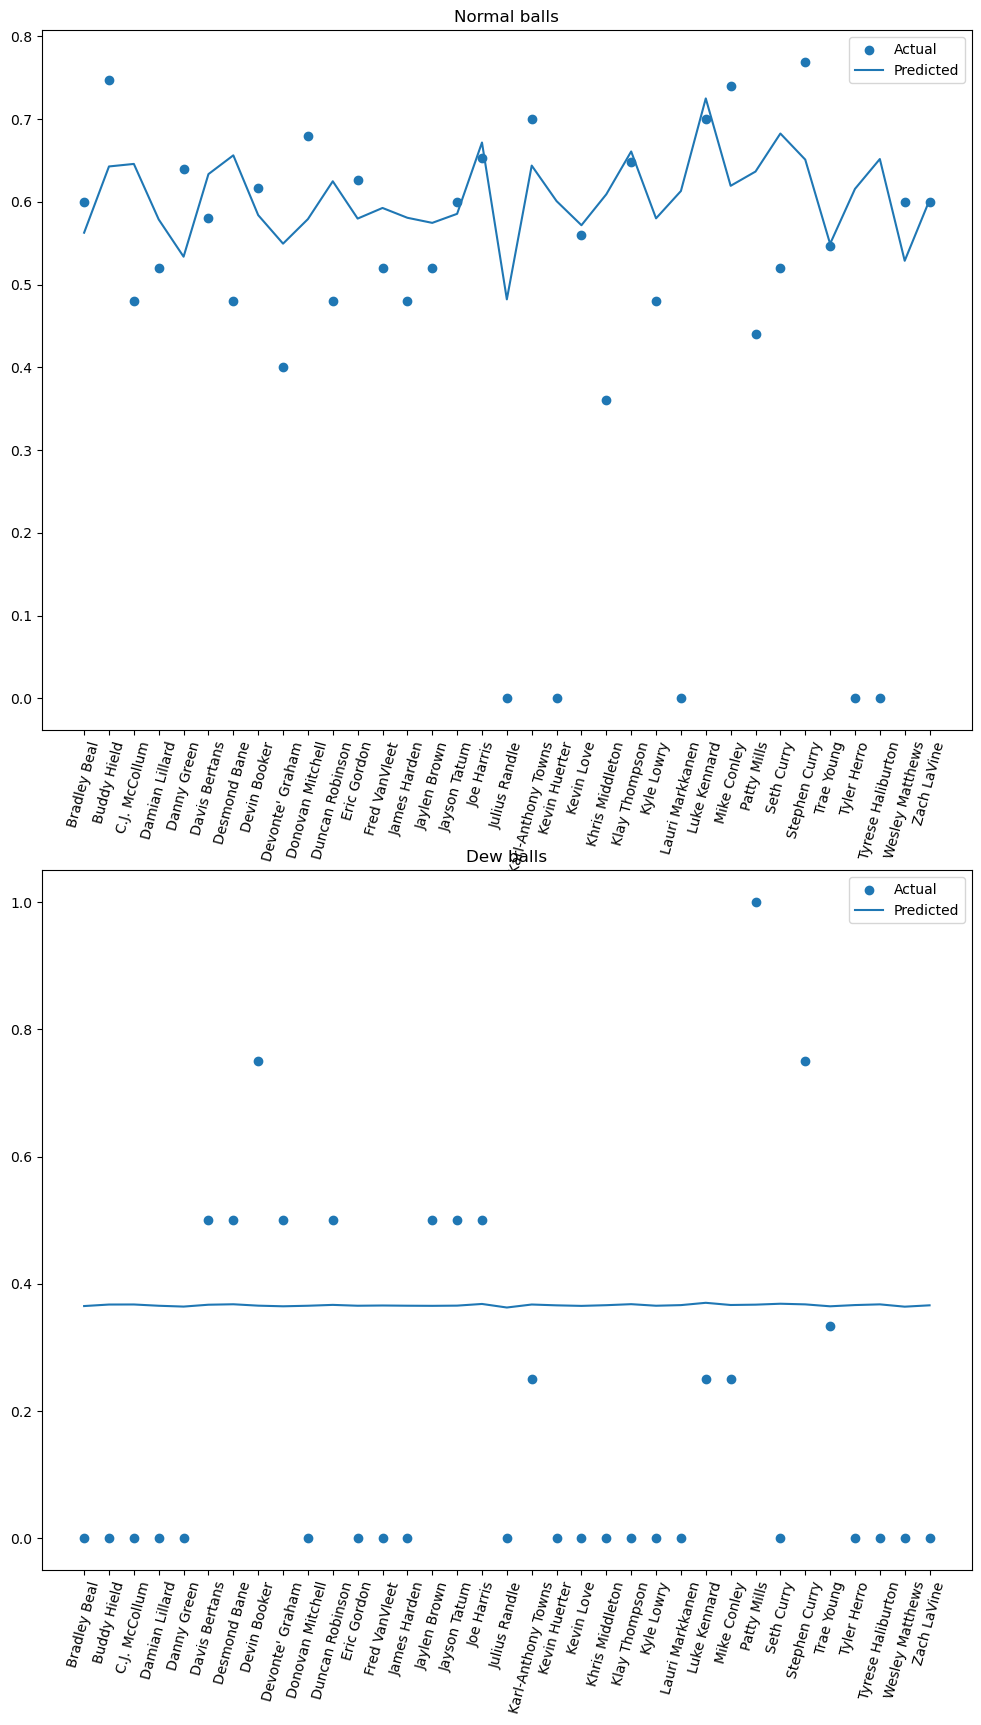

In [24]:
fig, ax = plt.subplots(2, figsize=(12,20))

ax[0].scatter(df_contest_merged['Player'], df_contest_merged['ContestMakeActual'], label='Actual')
ax[0].plot(df_contest_merged['Player'], df_contest_merged['ProjectedMake'], label='Predicted')
ax[0].legend()
ax[0].set_xticklabels(df_contest_merged['Player'], rotation = 75)
ax[0].set_title('Normal balls')

ax[1].scatter(df_contest_merged['Player'], df_contest_merged['dewContestMakeActual'], label='Actual')
ax[1].plot(df_contest_merged['Player'], df_contest_merged['DewProjectedMake'], label='Predicted')
ax[1].legend()
ax[1].set_xticklabels(df_contest_merged['Player'], rotation = 75)
ax[1].set_title('Dew balls')

plt.show()